In [136]:
from scipy.signal import welch, butter, filtfilt, find_peaks, medfilt
from scipy.interpolate import interp1d
import scipy.signal as scs
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

from scipy.signal.windows import triang

%matplotlib inline

Some preprocessing is needed before the first exercise.

In [139]:
#Functions for reprosessing

def minmax_normalize(chan: np.ndarray, min_value: int = 0, max_value: int = 1):
    chan = (chan - np.min(chan)) / (np.max(chan) - np.min(chan))
    return chan * (max_value - min_value) + min_value

def new_time_vector(df: pd.DataFrame, fs_new: int) -> np.ndarray:
    min_dt = df['timestamps_ecg'].iloc[-1]  # Last timestamp
    sampling_period = 1 / fs_new  # Time step for new sampling frequency
    n = int(fs_new * min_dt)  # Total number of samples
    return np.arange(0, n + 1) * sampling_period  # Generate uniform time array

def resample(chan: np.ndarray, orig_ts: np.ndarray, new_ts: np.ndarray) -> list[float]:
    # Allow extrapolation beyond the original data range
    sampled_signal = interp1d(orig_ts, chan, kind='cubic', bounds_error=False, fill_value="extrapolate")
    return sampled_signal(new_ts)

def butter_filter(chan: np.ndarray, fs: int, N: int = 3, lf: float = 0.5, hf: float = 40):
    b, a = butter(N, [lf, hf], fs = fs, btype = 'bandpass')  
    return filtfilt(b, a, chan) 

def moving_average_filter(chan: np.ndarray, win_size: int = 10):
    window = np.ones(win_size) / win_size
    return np.convolve(chan, window, mode='same')

In [141]:
#read the data
clean_signals = pd.read_csv('ecg_ppg_clean.csv') 
motion_signals = pd.read_csv('ecg_ppg_motion.csv')

# Display the data
display(clean_signals.head())
display(motion_signals.head())

,timestamps_ecg,ecg,timestamps_ppg_1_green,ppg_1_green,timestamps_ppg_1_red,ppg_1_red,timestamps_ppg_1_ir,ppg_1_ir,timestamps_ppg_2_green,ppg_2_green,timestamps_ppg_2_red,ppg_2_red,timestamps_ppg_2_ir,ppg_2_ir
0,725290.0,-1949.000000,725314.0,31289.000000,725314.0,2.274565e+06,725314.0,2.544369e+06,725301.0,28101.000000,725301.0,2.534342e+06,725301.0,2.540145e+06
1,725368.0,-1737.708861,725414.0,31255.336634,725414.0,2.274575e+06,725414.0,2.544328e+06,725401.0,28117.666667,725401.0,2.534269e+06,725401.0,2.539954e+06
2,725446.0,-1534.215190,725514.0,31204.029703,725514.0,2.274564e+06,725514.0,2.544304e+06,725501.0,28114.156863,725501.0,2.534142e+06,725501.0,2.539586e+06
3,725524.0,-1413.556962,725614.0,31186.504950,725614.0,2.274553e+06,725614.0,2.544289e+06,725601.0,28101.764706,725601.0,2.533956e+06,725601.0,2.539082e+06
4,725602.0,-1333.050633,725714.0,31166.029412,725714.0,2.274524e+06,725714.0,2.544271e+06,725701.0,28083.490196,725701.0,2.533720e+06,725701.0,2.538444e+06


,timestamps_ecg,ecg,timestamps_ppg_1_green,ppg_1_green,timestamps_ppg_1_red,ppg_1_red,timestamps_ppg_1_ir,ppg_1_ir,timestamps_ppg_2_green,ppg_2_green,timestamps_ppg_2_red,ppg_2_red,timestamps_ppg_2_ir,ppg_2_ir
0,763530.0,-1395.000000,763536.0,30428.000000,763536.0,2.275115e+06,763536.0,2.546066e+06,763512.0,21303.000000,763512.0,2.273412e+06,763512.0,2.267852e+06
1,763608.0,-1353.531646,763636.0,30448.792079,763636.0,2.275110e+06,763636.0,2.546067e+06,763612.0,21315.745098,763612.0,2.273418e+06,763612.0,2.267880e+06
2,763686.0,-1101.531646,763736.0,30440.178218,763736.0,2.275118e+06,763736.0,2.546061e+06,763712.0,21326.673267,763712.0,2.273422e+06,763712.0,2.267867e+06
3,763764.0,-878.544304,763836.0,30463.058824,763836.0,2.275130e+06,763836.0,2.546074e+06,763812.0,21333.656863,763812.0,2.273415e+06,763812.0,2.267844e+06
4,763842.0,-820.632911,763936.0,30473.504950,763936.0,2.275127e+06,763936.0,2.546079e+06,763912.0,21345.176471,763912.0,2.273398e+06,763912.0,2.267842e+06


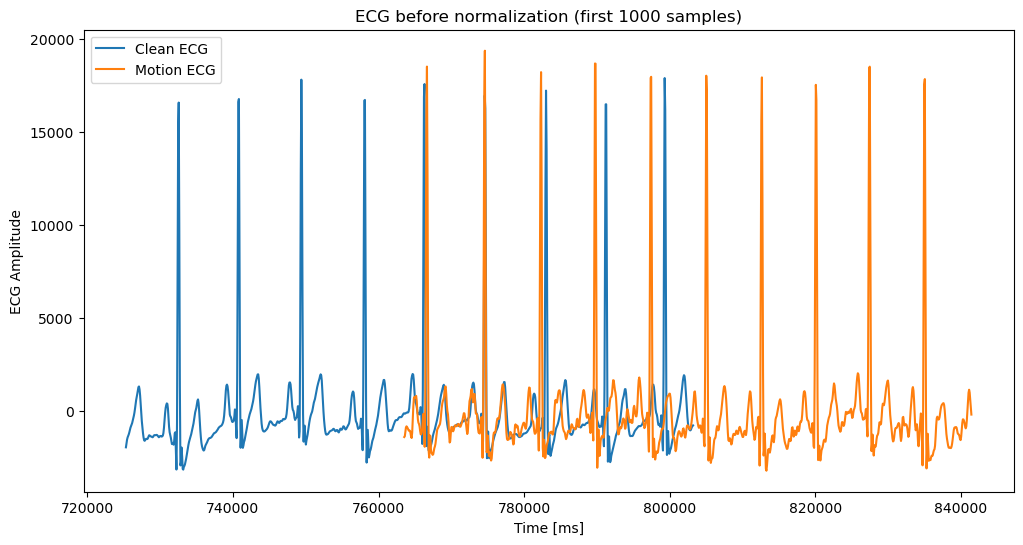

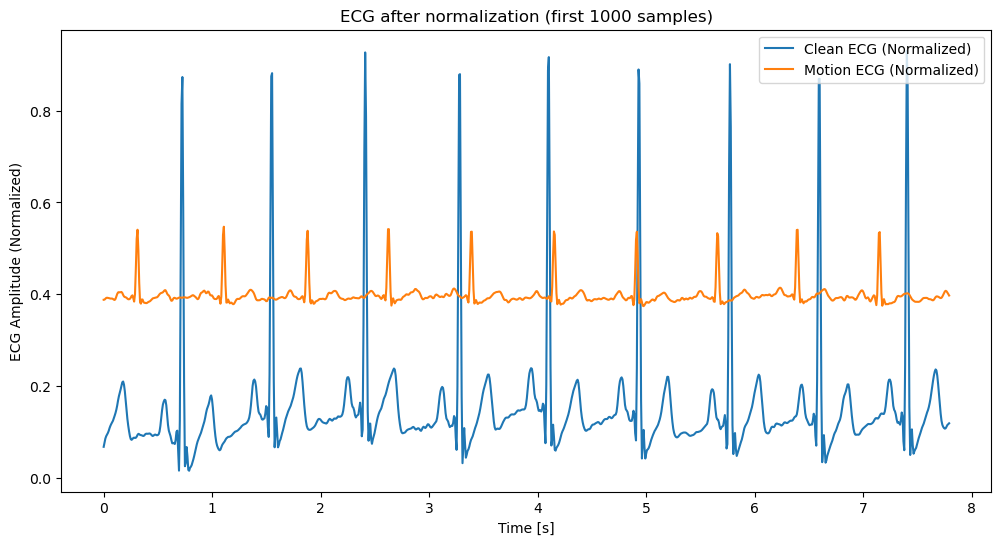

In [143]:
#Next using the preprocessing functions to process signals before peak detection

#Using the frequency that was presented previous exercises. 
fs_new = 200

# taking copies, that we don't overwrite the orginal datframes
normalized_clean = clean_signals.copy()
normalized_motion = motion_signals.copy()

# Convert timestamps from milliseconds to seconds
normalized_clean['timestamps_ecg'] = (clean_signals['timestamps_ecg'] - clean_signals['timestamps_ecg'].values[0]) / 10000
normalized_motion['timestamps_ecg'] = (motion_signals['timestamps_ecg'] - motion_signals['timestamps_ecg'].values[0]) / 10000
normalized_clean['timestamps_ppg_1_green'] = (clean_signals['timestamps_ppg_1_green'] - clean_signals['timestamps_ppg_1_green'].values[0]) / 10000
normalized_motion['timestamps_ppg_1_green'] = (motion_signals['timestamps_ppg_1_green'] - motion_signals['timestamps_ppg_1_green'].values[0]) / 10000

# Normalize ECG signals
normalized_clean['ecg'] = minmax_normalize(clean_signals['ecg'].dropna())
normalized_motion['ecg'] = minmax_normalize(motion_signals['ecg'].dropna())

#I also normalize the PPG signals that I can use it
normalized_clean['ppg_1_green'] = -normalized_clean['ppg_1_green']
normalized_clean['ppg_1_green'] = minmax_normalize(clean_signals['ppg_1_green'].dropna())

# Plot the ECG signals before normalization
plt.figure(figsize=(12, 6))
plt.title('ECG before normalization (first 1000 samples)')
sns.lineplot(x=clean_signals['timestamps_ecg'][:1000], y=clean_signals['ecg'][:1000], label='Clean ECG')
sns.lineplot(x=motion_signals['timestamps_ecg'][:1000], y=motion_signals['ecg'][:1000], label='Motion ECG')
plt.xlabel('Time [ms]')
plt.ylabel('ECG Amplitude')
plt.legend()
plt.show()

# Plot the ECG signals after normalization
plt.figure(figsize=(12, 6))
plt.title('ECG after normalization (first 1000 samples)')
sns.lineplot(x=normalized_clean['timestamps_ecg'][:1000], y=normalized_clean['ecg'][:1000], label='Clean ECG (Normalized)')
sns.lineplot(x=normalized_motion['timestamps_ecg'][:1000], y=normalized_motion['ecg'][:1000], label='Motion ECG (Normalized)')
plt.xlabel('Time [s]')
plt.ylabel('ECG Amplitude (Normalized)')
plt.legend()
plt.show()

In [145]:
sig_cols = ['ecg']  # Signal column
ts_cols = ['timestamps_ecg']  # Timestamp column

# Initialize new DataFrames for resampled data
resampled_clean_data = pd.DataFrame(columns=['time', 'ecg'])
resampled_motion_data = pd.DataFrame(columns=['time', 'ecg'])

# Generate new time vectors
time_new_clean = new_time_vector(normalized_clean, fs_new)
resampled_clean_data['time'] = time_new_clean

time_new_motion = new_time_vector(normalized_motion, fs_new)
resampled_motion_data['time'] = time_new_motion

print('Length of the new time domain for clean signals:', max(time_new_clean), 's')
print('Length of the new time domain for motion signals:', max(time_new_motion), 's')

# Resample only ECG signals
resampled_clean_data['ecg'] = resample(normalized_clean['ecg'].dropna(), normalized_clean['timestamps_ecg'].dropna(), time_new_clean)
resampled_motion_data['ecg'] = resample(normalized_motion['ecg'].dropna(), normalized_motion['timestamps_ecg'].dropna(), time_new_motion)

Length of the new time domain for clean signals: 122.46000000000001 s
Length of the new time domain for motion signals: 124.885 s


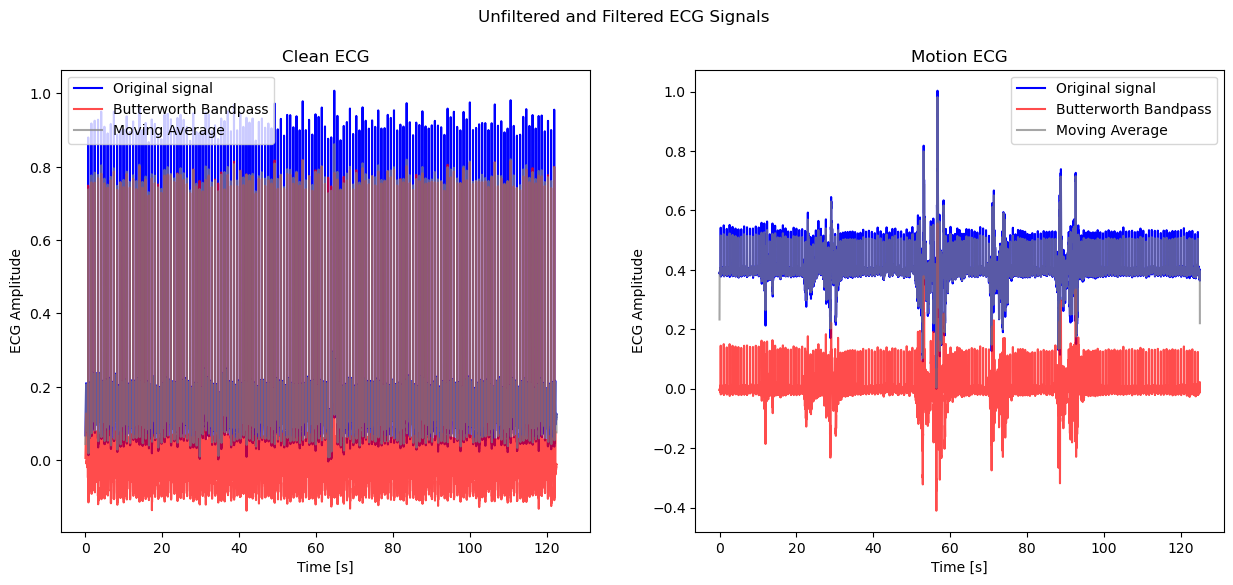

In [147]:
# then filtering the signals with butterworth filter and moving average filter

# Apply Butterworth bandpass filter to clean and motion ECG signals
bf_ecg_clean = butter_filter(resampled_clean_data['ecg'], fs_new)
bf_ecg_motion = butter_filter(resampled_motion_data['ecg'], fs_new)

# Moving Average filter
ma_ecg_clean = moving_average_filter(resampled_clean_data['ecg'],  5)
ma_ecg_motion = moving_average_filter(resampled_motion_data['ecg'],  5)

# Ensure the filtered signals have the same length as time vectors
bf_ecg_clean = bf_ecg_clean[:len(resampled_clean_data['time'])]
bf_ecg_motion = bf_ecg_motion[:len(resampled_motion_data['time'])]

# Plot the Unfiltered vs. Filtered ECG Signals
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
fig.suptitle('Unfiltered and Filtered ECG Signals')

# Plot for Clean ECG Signal
sns.lineplot(data=resampled_clean_data, x='time', y='ecg', label='Original signal', color='blue', ax=ax[0])
sns.lineplot(x=resampled_clean_data['time'], y=bf_ecg_clean, label='Butterworth Bandpass', color='red', alpha=0.7, ax=ax[0])
sns.lineplot(x=resampled_clean_data['time'], y=ma_ecg_clean, label='Moving Average', color='grey', alpha=0.7, ax=ax[0])
ax[0].set(title='Clean ECG', xlabel='Time [s]', ylabel='ECG Amplitude')

# Plot for Motion ECG Signal
sns.lineplot(data=resampled_motion_data, x='time', y='ecg', label='Original signal', color='blue', ax=ax[1])
sns.lineplot(x=resampled_motion_data['time'], y=bf_ecg_motion, label='Butterworth Bandpass', color='red', alpha=0.7, ax=ax[1])
sns.lineplot(x=resampled_motion_data['time'], y=ma_ecg_motion, label='Moving Average', color='grey', alpha=0.7, ax=ax[1])
ax[1].set(title='Motion ECG', xlabel='Time [s]', ylabel='ECG Amplitude')

plt.legend()
plt.show()

1. Segment the signals into 10 s non overlapping segments. Ideally the code allows for overlapping segmentation. 

In [150]:
# Create DataFrames to store preprocessed signals
preprocessed_clean_data = pd.DataFrame()
preprocessed_motion_data = pd.DataFrame()

# Copy time and original signals
preprocessed_clean_data['time'] = resampled_clean_data['time']
preprocessed_clean_data['ecg'] = resampled_clean_data['ecg']

preprocessed_motion_data['time'] = resampled_motion_data['time']
preprocessed_motion_data['ecg'] = resampled_motion_data['ecg']

# Apply Butterworth and Moving Average filters
preprocessed_clean_data['ecg_butterworth'] = butter_filter(resampled_clean_data['ecg'], fs_new)
preprocessed_clean_data['ecg_moving_avg'] = moving_average_filter(resampled_clean_data['ecg'], 5)

preprocessed_motion_data['ecg_butterworth'] = butter_filter(resampled_motion_data['ecg'], fs_new)
preprocessed_motion_data['ecg_moving_avg'] = moving_average_filter(resampled_motion_data['ecg'], 5)

# Ensure column order is correct
expected_columns = ['time', 'ecg', 'ecg_butterworth', 'ecg_moving_avg']
preprocessed_clean_data = preprocessed_clean_data[expected_columns]
preprocessed_motion_data = preprocessed_motion_data[expected_columns]

print("Preprocessed clean and motion signals saved successfully!")

Preprocessed clean and motion signals saved successfully!


In [152]:
def segment_signal(signal: np.ndarray, fs: float, segment_duration: float, overlap: float = 0) -> np.ndarray:
    """
    Segment a 1D signal into segments of a given duration (in seconds) with optional overlap.
    """
    
    seg_length = int(segment_duration * fs)     # number of samples per segment
    overlap_length = int(overlap * fs)            # number of samples to overlap
    step = seg_length - overlap_length            # step size between segments

    segments = []
    # Loop over the signal with the defined step size.
    for start in range(0, len(signal) - seg_length + 1, step):
        segment = signal[start:start + seg_length]
        segments.append(segment)

    # Convert list of segments to a 2D numpy array (each row is a segment)
    return np.array(segments)

Total segments created: 12
Each segment has 2000 samples (should be 2000).


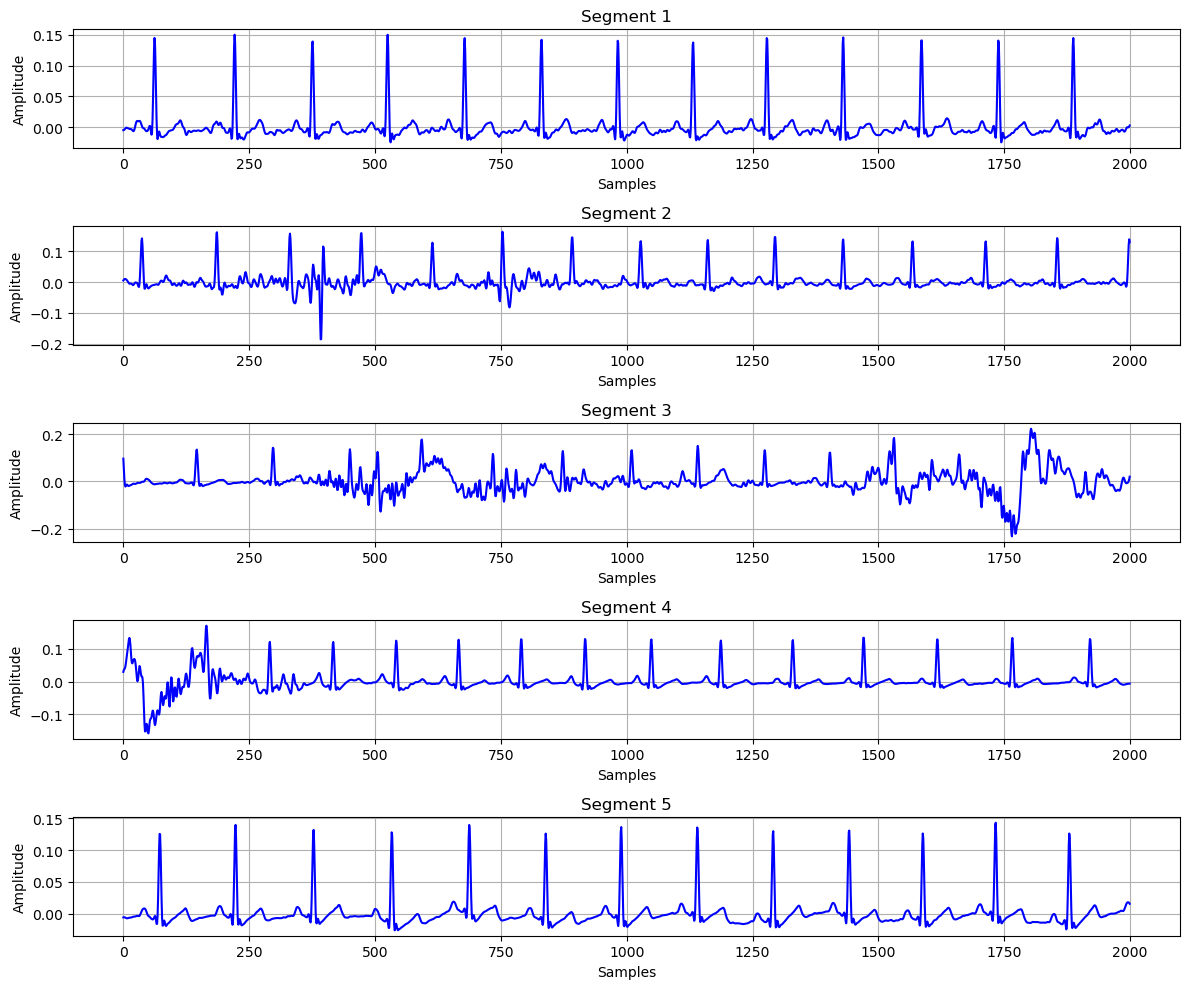

In [154]:
segment_duration = 10       # Each segment is 10 seconds long.
overlap = 0                 # Change this value if you want overlapping segments.

# Segment the signal.
segments_motion = segment_signal(preprocessed_motion_data['ecg_butterworth'], fs_new, segment_duration, overlap)
    
print(f"Total segments created: {segments_motion.shape[0]}")
print(f"Each segment has {segments_motion.shape[1]} samples (should be {segment_duration * fs_new}).")

# Determine the number of segments to plot (up to 5)
n_plots = min(5, segments_motion.shape[0])

plt.figure(figsize=(12, 2 * n_plots))

# Loop through only the first n_plots segments
for i in range(n_plots):
    plt.subplot(n_plots, 1, i+1)
    plt.plot(segments_motion[i], color='blue')
    plt.title(f"Segment {i+1}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.tight_layout()
plt.show()

2. Compute ensemble averaged waveform of the heart beats (align found beats from maxima, plot all of them in figure and do samplewise averaged waveform i.e. ensemble averaged). 

In [157]:

ATHRS = 0.1 # Global amplitude threshold
RRMIN = int(0.4 * fs_new) # R-peaks physiologically cannot be closer than 200ms

peak_clean, _ = find_peaks(preprocessed_clean_data['ecg_butterworth'], distance=RRMIN, height = ATHRS)
peak_motion, _ = find_peaks(preprocessed_motion_data['ecg_butterworth'], distance=RRMIN, height = ATHRS)

In [159]:
def extract_waveform(arr, locs):
    w1, w2 = int(0.3*fs_new), int(0.35*fs_new)
    waveforms = []
    for loc in locs:
        if (loc - w1 > 0) and (loc + w2 < len(arr)):
            l1, l2 = loc - w1, loc + w2
            waveforms.append(arr[l1:l2])
    return np.array(waveforms)

In [161]:
waveforms_ecg_c = extract_waveform(preprocessed_clean_data['ecg_butterworth'], peak_clean)
waveforms_ecg_m = extract_waveform(preprocessed_motion_data['ecg_butterworth'], peak_motion)

avg_c = np.mean(np.array(waveforms_ecg_c), axis=0)
avg_m = np.mean(np.array(waveforms_ecg_m), axis=0)

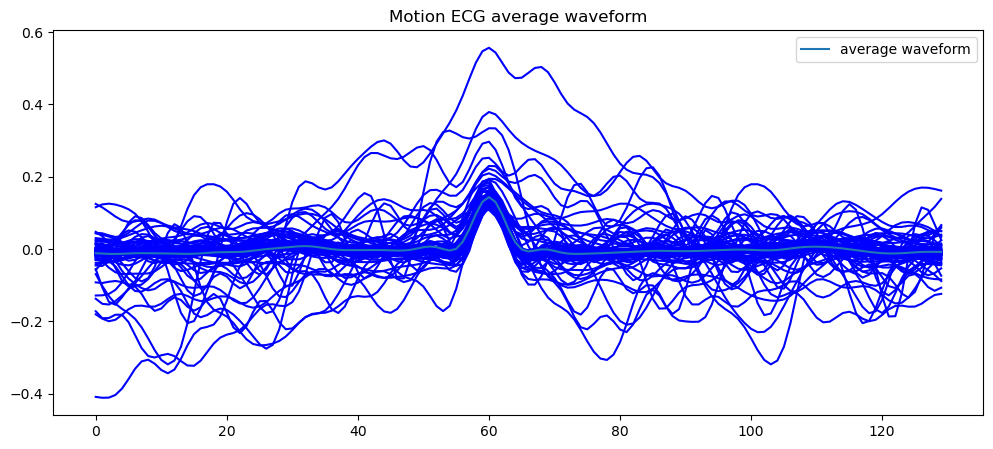

In [163]:
plt.figure(figsize=(12,5))
for wave in waveforms_ecg_m:
    plt.plot(wave, color='blue')
plt.plot(avg_m, label='average waveform')
plt.title('Motion ECG average waveform')
plt.legend()

Here is another way, how I tried to extract the waveform from signal.

Detected 199 R-peaks in the full signal.
Extracted 199 beats from the full signal.


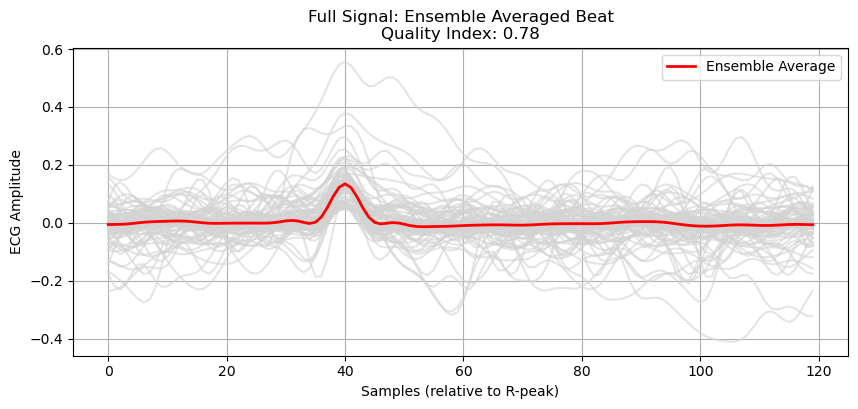

Full Signal: Detected 199 R-peaks, Quality Index = 0.78


In [166]:
def detect_r_peaks(signal: np.ndarray, fs: float, min_distance_sec: float = 0.25, threshold_factor: float = 1.0) -> np.ndarray:
    """
    Detect R-peaks in an ECG signal using a threshold based on mean and standard deviation.
    """
    threshold = np.mean(signal) + threshold_factor * np.std(signal)
    min_distance_samples = int(min_distance_sec * fs)
    peaks, _ = find_peaks(signal, height=threshold, distance=min_distance_samples)
    return peaks

def extract_beats(signal: np.ndarray, peaks: np.ndarray, fs: float, window_before: float = 0.2, window_after: float = 0.4) -> np.ndarray:
    """
    Extract beat windows from the signal around each R-peak.
    Returns a 2D array where each row is one beat.
    """
    n_before = int(window_before * fs)
    n_after = int(window_after * fs)
    beats = []
    for peak in peaks:
        if peak - n_before >= 0 and peak + n_after <= len(signal):
            beats.append(signal[peak - n_before : peak + n_after])
    return np.array(beats)

def compute_quality_index(beats: np.ndarray):
    """
    Computes the quality index as follows:
      1. Compute the median (samplewise) beat.
      2. For each beat, compute the Pearson correlation coefficient with the median.
      3. The quality index is the average correlation.
    """
    median_beat = np.median(beats, axis=0)
    correlations = []
    for beat in beats:
        corr = np.corrcoef(beat, median_beat)[0, 1]
        correlations.append(corr)
    quality_index = np.mean(correlations)
    return quality_index, median_beat, correlations


FS = 200  # Sampling frequency in Hz

# Detect R-peaks on the full signal
r_peaks_full = detect_r_peaks(bf_ecg_motion, FS, min_distance_sec=0.25, threshold_factor=1.0)
if len(r_peaks_full) == 0:
    print("No R-peaks detected in the full signal.")
else:
    print(f"Detected {len(r_peaks_full)} R-peaks in the full signal.")

    # Extract beats around each R-peak from the full signal
    beats_full = extract_beats(bf_ecg_motion, r_peaks_full, FS, window_before=0.2, window_after=0.4)
    if beats_full.size == 0:
        print("No beats could be extracted from the full signal.")
    else:
        print(f"Extracted {beats_full.shape[0]} beats from the full signal.")

        #  Compute the ensemble average and quality index over the full signal
        ensemble_avg_full = np.mean(beats_full, axis=0)
        quality_index_full, median_beat_full, correlations_full = compute_quality_index(beats_full)

        plt.figure(figsize=(10, 4))
        # Plot individual beats in light grey
        for beat in beats_full:
            plt.plot(beat, color='lightgrey', alpha=0.6)
        # Overlay the ensemble average in red
        plt.plot(ensemble_avg_full, color='red', linewidth=2, label='Ensemble Average')
        plt.title(f'Full Signal: Ensemble Averaged Beat\nQuality Index: {quality_index_full:.2f}')
        plt.xlabel('Samples (relative to R-peak)')
        plt.ylabel('ECG Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Full Signal: Detected {len(r_peaks_full)} R-peaks, Quality Index = {quality_index_full:.2f}")


3. Compute time intervals from ensemble averaged waveform. Try to find t-wave from ECG and the diastolic peak from PPG. 

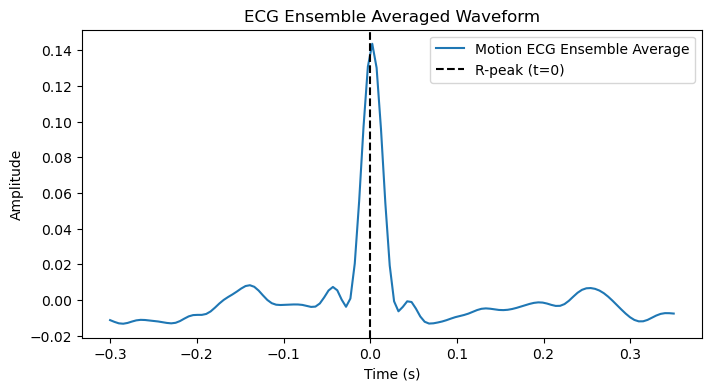

In [169]:
w1 = int(0.3*fs_new)
w2 = int(0.35*fs_new)

# Create a time axis for the averaged waveform.
# It will run from -w1/fs_new seconds to w2/fs_new seconds.
time_axis = np.linspace(-w1/fs_new, w2/fs_new, avg_m.size)

# Plot the ensemble averaged ECG for visual inspection.
plt.figure(figsize=(8, 4))
plt.plot(time_axis, avg_m, label="Motion ECG Ensemble Average")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG Ensemble Averaged Waveform")
plt.axvline(0, color='k', linestyle='--', label="R-peak (t=0)")
plt.legend()
plt.show()

T-wave detected at 0.254 seconds after the R-peak.


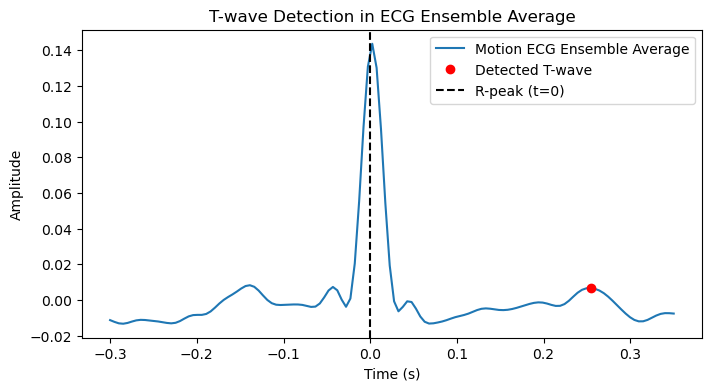

In [171]:
# Define the search window in seconds 
t_search_start = 0.1  # seconds after the R-peak
t_search_end = 0.4    # seconds after the R-peak

# Find the indices corresponding to these times
start_idx = np.searchsorted(time_axis, t_search_start)
end_idx = np.searchsorted(time_axis, t_search_end)

# Use find_peaks to detect peaks in the defined window
t_peaks_m, properties = find_peaks(avg_m[start_idx:end_idx], height=0)

if t_peaks_m.size > 0:
    # Get the first peak (or choose based on additional criteria)
    t_wave_idx = t_peaks_m[0] + start_idx  # Adjust index to the full averaged waveform
    t_wave_time = time_axis[t_wave_idx]
    print(f"T-wave detected at {t_wave_time:.3f} seconds after the R-peak.")
    
    # Plot the detected T-wave on the ensemble average
    plt.figure(figsize=(8, 4))
    plt.plot(time_axis, avg_m, label="Motion ECG Ensemble Average")
    plt.plot(time_axis[t_wave_idx], avg_m[t_wave_idx], 'ro', label="Detected T-wave")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("T-wave Detection in ECG Ensemble Average")
    plt.axvline(0, color='k', linestyle='--', label="R-peak (t=0)")
    plt.legend()
    plt.show()


In [173]:
sig = ['ppg']  # Signal column
ts = ['timestamps_ppg']  # Timestamp column

# Initialize new DataFrames for resampled data
resampled_clean_ppg = pd.DataFrame(columns=['time', 'ppg'])
resampled_motion_ppg = pd.DataFrame(columns=['time', 'ppg'])

# Generate new time vectors
time_clean_ppg = new_time_vector(normalized_clean, fs_new)
resampled_clean_ppg['time'] = time_clean_ppg

time_motion_ppg = new_time_vector(normalized_motion, fs_new)
resampled_motion_ppg['time'] = time_motion_ppg

print('Length of the new time domain for clean signals:', max(time_clean_ppg), 's')
print('Length of the new time domain for motion signals:', max(time_motion_ppg), 's')

# Resample only ECG signals
resampled_clean_ppg['ppg'] = resample(normalized_clean['ppg_1_green'].dropna(), normalized_clean['timestamps_ppg_1_green'].dropna(), time_clean_ppg)
resampled_motion_ppg['ppg'] = resample(normalized_motion['ppg_1_green'].dropna(), normalized_motion['timestamps_ppg_1_green'].dropna(), time_motion_ppg)

# Create DataFrames to store preprocessed signals
preprocessed_clean_ppg = pd.DataFrame()
preprocessed_motion_ppg = pd.DataFrame()

# Copy time and original signals
preprocessed_clean_ppg['time'] = resampled_clean_ppg['time']
preprocessed_clean_ppg['ppg'] = resampled_clean_ppg['ppg']

preprocessed_motion_ppg['time'] = resampled_motion_ppg['time']
preprocessed_motion_ppg['ppg'] = resampled_motion_ppg['ppg']

# Apply Butterworth and Moving Average filters
preprocessed_clean_ppg['ppg_butterworth'] = butter_filter(resampled_clean_ppg['ppg'], fs_new)
preprocessed_clean_ppg['ppg_moving_avg'] = moving_average_filter(resampled_clean_ppg['ppg'], 5)

preprocessed_motion_ppg['ppg_butterworth'] = butter_filter(resampled_motion_ppg['ppg'], fs_new)
preprocessed_motion_ppg['ppg_moving_avg'] = moving_average_filter(resampled_motion_ppg['ppg'], 5)

# Ensure column order is correct
expected_columns = ['time', 'ppg', 'ppg_butterworth', 'ppg_moving_avg']
preprocessed_clean_ppg = preprocessed_clean_ppg[expected_columns]
preprocessed_motion_ppg = preprocessed_motion_ppg[expected_columns]

Length of the new time domain for clean signals: 122.46000000000001 s
Length of the new time domain for motion signals: 124.885 s


In [175]:
peak_clean_ppg, _ = find_peaks(preprocessed_clean_ppg['ppg_butterworth'],distance=RRMIN, height = ATHRS)
peak_motion_ppg, _ = find_peaks(preprocessed_motion_ppg['ppg_butterworth'], distance=RRMIN, height = ATHRS)

waveforms_ppg_c = extract_waveform(preprocessed_clean_ppg['ppg_butterworth'], peak_clean_ppg)
waveforms_ppg_m = extract_waveform(preprocessed_motion_ppg['ppg_butterworth'], peak_motion_ppg)

avg_ppg_c = np.mean(np.array(waveforms_ppg_c), axis=0)
avg_ppg_m = np.mean(np.array(waveforms_ppg_m), axis=0)

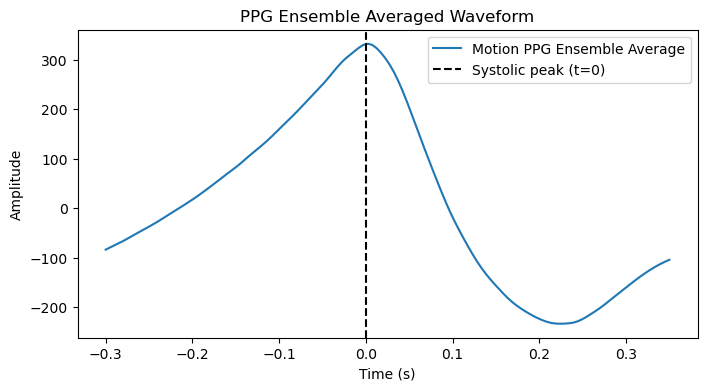

In [177]:
# Create a time axis for the averaged waveform.
# It will run from -w1/fs_new seconds to w2/fs_new seconds.
time_axis_ppg = np.linspace(-w1/fs_new, w2/fs_new, avg_ppg_m.size)

# Plot the ensemble averaged ECG for visual inspection.
plt.figure(figsize=(8, 4))
plt.plot(time_axis_ppg, avg_ppg_m, label="Motion PPG Ensemble Average")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("PPG Ensemble Averaged Waveform")
plt.axvline(0, color='k', linestyle='--', label="Systolic peak (t=0)")
plt.legend()
plt.show()

Detected diastolic peaks: []
No diastolic peak detected in the specified window.


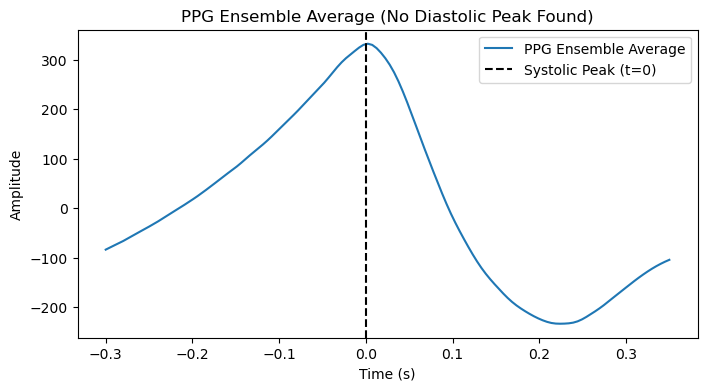

In [179]:
# Define a search window for the diastolic peak.
#    The diastolic peak is expected to occur after the systolic peak.
#    For example, we might search between 0.2 and 0.5 seconds after the systolic peak.
d_search_start = 0.2  # seconds after the systolic peak
d_search_end   = 0.5  # seconds after the systolic peak

# Find the indices corresponding to these times in the time axis.
start_idx_ppg = np.searchsorted(time_axis_ppg, d_search_start)
end_idx_ppg   = np.searchsorted(time_axis_ppg, d_search_end)

# 4. Detect the diastolic peak using find_peaks.
#    Adjust the parameters (e.g., height, prominence) as needed based on your data.
d_peaks, d_properties = find_peaks(avg_ppg_m[start_idx_ppg:end_idx_ppg], height=0)

print("Detected diastolic peaks:", d_peaks)

if d_peaks.size > 0:
    # Adjust the index back to the full averaged waveform.
    d_peak_idx = d_peaks[0] + start_idx_ppg
    d_peak_time = time_axis_ppg[d_peak_idx]
    print(f"Diastolic peak detected at {d_peak_time:.3f} seconds after the systolic peak.")
    
    # Plot the detected diastolic peak on the ensemble-averaged PPG waveform.
    plt.figure(figsize=(8, 4))
    plt.plot(time_axis_ppg, avg_ppg_m, label="PPG Ensemble Average")
    plt.plot(time_axis_ppg[d_peak_idx], avg_ppg_m[d_peak_idx], 'ro', label="Detected Diastolic Peak")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Diastolic Peak Detection in PPG Ensemble Average")
    plt.axvline(0, color='k', linestyle='--', label="Systolic Peak (t=0)")
    plt.legend()
    plt.show()
else:
    print("No diastolic peak detected in the specified window.")
    # Optionally, plot the ensemble average even if no peak was detected for inspection:
    plt.figure(figsize=(8, 4))
    plt.plot(time_axis_ppg, avg_ppg_m, label="PPG Ensemble Average")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("PPG Ensemble Average (No Diastolic Peak Found)")
    plt.axvline(0, color='k', linestyle='--', label="Systolic Peak (t=0)")
    plt.legend()
    plt.show()

4. Detect/compute a metric/visualize between sinus rhythm and atrial fibrillation signal. Idea is to develop a piece of code that can reveal differences between these signals and be used in atrial fibrillation detection algorithms. Full detection pipeline not needed. The fs in signals is 200.

In [182]:
#read the data
ecg_afib = pd.read_csv('ecg_afib.csv') 
ecg_sinus = pd.read_csv('ecg_sinus.csv')
ppg_afib = pd.read_csv('ppg_afib.csv') 
ppg_sinus = pd.read_csv('ppg_sinus.csv')

# Display the data
display(ecg_afib.head())
display(ecg_sinus.head())
display(ppg_afib.head())
display(ppg_sinus.head())

,1.495003358949337224e-01
0,0.143205
1,0.156679
2,0.164095
3,0.169752
4,0.148637


,1.180077137884774918e-01
0,0.164484
1,0.099061
2,0.111331
3,0.106967
4,0.035562


,3.044267520154193482e-02
0,0.033820
1,0.003647
2,-0.047005
3,-0.025571
4,-0.019123


,3.394712695111204437e-02
0,0.050259
1,0.027962
2,0.055216
3,0.076682
4,0.113898


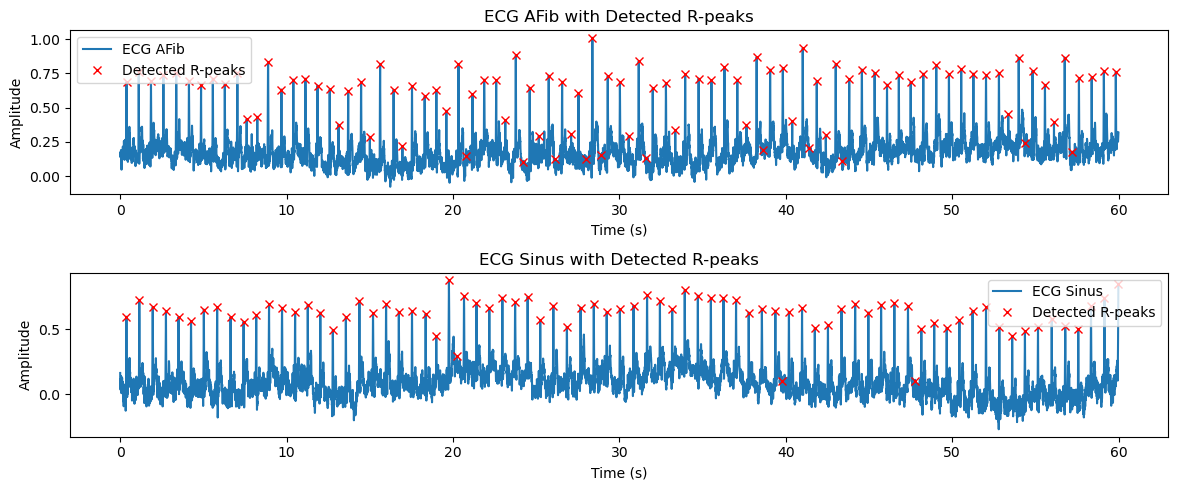

ECG AFib HRV Metrics:
  Mean RR Interval: 0.619 s
  SDNN: 0.136 s
  RMSSD: 0.149 s

ECG Sinus HRV Metrics:
  Mean RR Interval: 0.755 s
  SDNN: 0.100 s
  RMSSD: 0.107 s


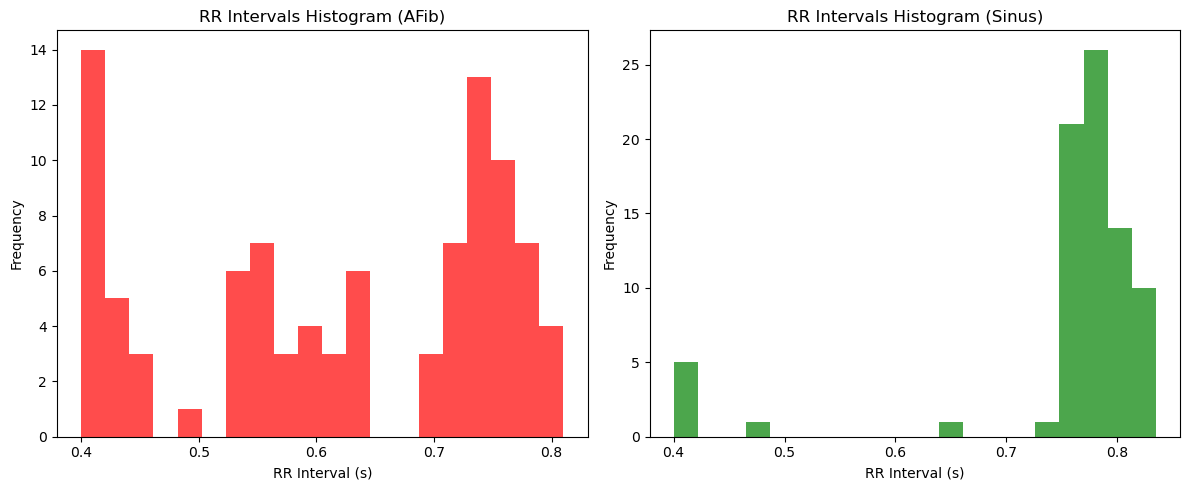

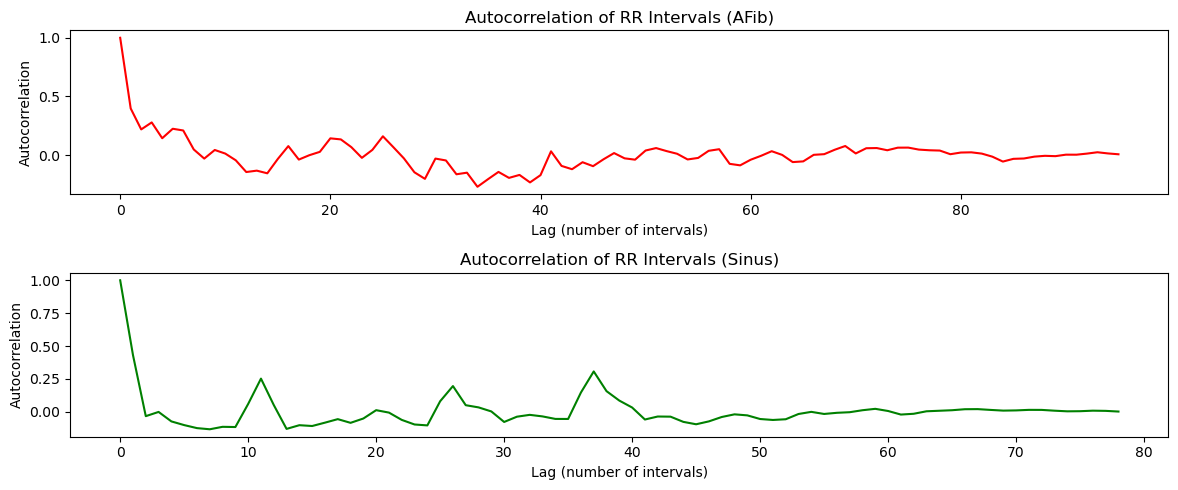

In [184]:
# Sampling frequency in Hz
fs = 200

# Create Time Vectors, beacuse the CSV files do not contain a time column, only the signals
time_ecg_afib = np.arange(len(ecg_afib)) / fs
time_ecg_sinus = np.arange(len(ecg_sinus)) / fs

# ECG signal is in the first column of each CSV:
signal_ecg_afib = ecg_afib.iloc[:, 0].values
signal_ecg_sinus = ecg_sinus.iloc[:, 0].values

# Detect R-peaks in ECG

# Use a basic height threshold, here chosen as the mean value of the signal.
peaks_afib, _ = find_peaks(signal_ecg_afib, distance=RRMIN, height = ATHRS)
peaks_sinus, _ = find_peaks(signal_ecg_sinus, distance=RRMIN, height = ATHRS)

# Visualize the detected peaks for both signals.
plt.figure(figsize=(12, 5))
plt.subplot(2,1,1)
plt.plot(time_ecg_afib, signal_ecg_afib, label='ECG AFib')
plt.plot(time_ecg_afib[peaks_afib], signal_ecg_afib[peaks_afib], 'rx', label='Detected R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG AFib with Detected R-peaks')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time_ecg_sinus, signal_ecg_sinus, label='ECG Sinus')
plt.plot(time_ecg_sinus[peaks_sinus], signal_ecg_sinus[peaks_sinus], 'rx', label='Detected R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG Sinus with Detected R-peaks')
plt.legend()
plt.tight_layout()
plt.show()

# Compute RR Intervals (in seconds)
rr_intervals_afib = np.diff(peaks_afib) / fs
rr_intervals_sinus = np.diff(peaks_sinus) / fs

# Compute HRV Metrics
def compute_hrv_metrics(rr_intervals):
    mean_rr = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    return mean_rr, sdnn, rmssd

mean_rr_afib, sdnn_afib, rmssd_afib = compute_hrv_metrics(rr_intervals_afib)
mean_rr_sinus, sdnn_sinus, rmssd_sinus = compute_hrv_metrics(rr_intervals_sinus)

'''
These HRV metrics help quantify the irregularity in heart rhythms. 
Typically, an atrial fibrillation signal will exhibit higher variability (higher SDNN and RMSSD) 
compared to a sinus rhythm, which is more regular.

'''

print("ECG AFib HRV Metrics:")
print(f"  Mean RR Interval: {mean_rr_afib:.3f} s")
print(f"  SDNN: {sdnn_afib:.3f} s")
print(f"  RMSSD: {rmssd_afib:.3f} s")

print("\nECG Sinus HRV Metrics:")
print(f"  Mean RR Interval: {mean_rr_sinus:.3f} s")
print(f"  SDNN: {sdnn_sinus:.3f} s")
print(f"  RMSSD: {rmssd_sinus:.3f} s")

# Visualize the RR interval distributions.
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(rr_intervals_afib, bins=20, color='red', alpha=0.7)
plt.title('RR Intervals Histogram (AFib)')
plt.xlabel('RR Interval (s)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(rr_intervals_sinus, bins=20, color='green', alpha=0.7)
plt.title('RR Intervals Histogram (Sinus)')
plt.xlabel('RR Interval (s)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Compute Autocorrelation of the RR Interval Series
def autocorrelation(x):
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size // 2:]
    # Normalize so that the zero-lag value is 1
    result = result / result[0]
    return result

autocorr_afib = autocorrelation(rr_intervals_afib)
autocorr_sinus = autocorrelation(rr_intervals_sinus)

'''
Autocorrelation measures how similar a signal is to itself at different lags. In a regular (sinus) rhythm,
the autocorrelation function tends to show clear, repeating peaks at regular intervals. In contrast, 
the autocorrelation of an AFib signal (which is irregular) will decay more rapidly and show less structure. 
'''

'''
Lag here represents the number of intervals (or time steps) by which the signal must be shifted to achieve 
the maximum self-similarity (aside from the trivial zero-shift case).
It is computed by finding the difference between the index of the maximum autocorrelation value and the index corresponding to zero lag.

'''

# Create lag vectors (in number of intervals).
lags_afib = np.arange(len(autocorr_afib))
lags_sinus = np.arange(len(autocorr_sinus))

plt.figure(figsize=(12, 5))
plt.subplot(2,1,1)
plt.plot(lags_afib, autocorr_afib, 'r-')
plt.title('Autocorrelation of RR Intervals (AFib)')
plt.xlabel('Lag (number of intervals)')
plt.ylabel('Autocorrelation')

plt.subplot(2,1,2)
plt.plot(lags_sinus, autocorr_sinus, 'g-')
plt.title('Autocorrelation of RR Intervals (Sinus)')
plt.xlabel('Lag (number of intervals)')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()


AFib has irregular, scattered RR intervals, shown by its wide histogram distribution and rapidly decreasing autocorrelation, indicating chaotic heart rhythms. Sinus Rhythm is more stable, with RR intervals clustering around a mean value and showing periodicity in the autocorrelation plot.
AFib’s lower mean RR interval and higher variability reflect an erratic heartbeat, while Sinus Rhythm maintains a more predictable pattern.

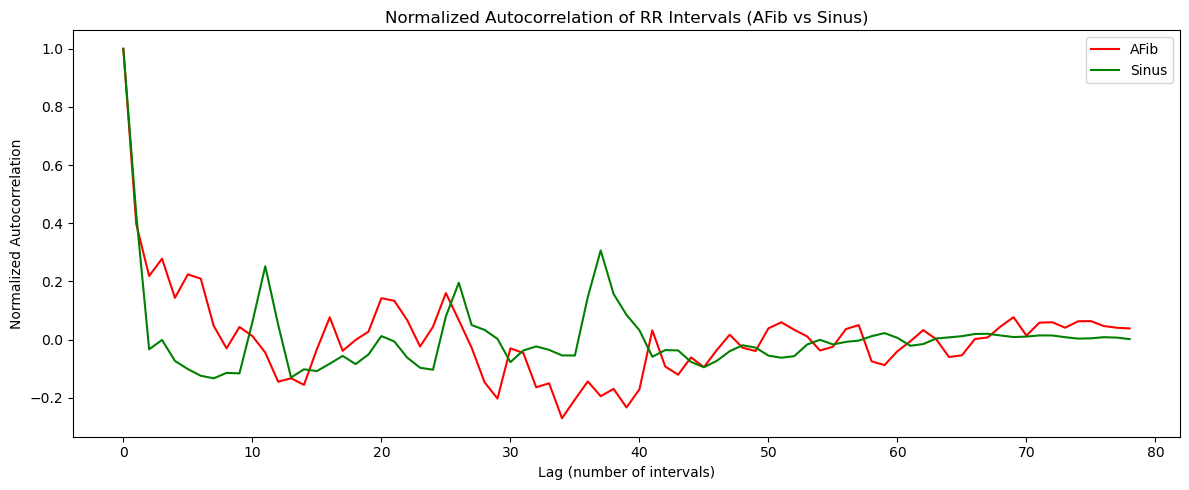

In [187]:
autocorr_afib = autocorrelation(rr_intervals_afib)
autocorr_sinus = autocorrelation(rr_intervals_sinus)

# Create lag vectors (in number of intervals)
lags_afib = np.arange(len(autocorr_afib))
lags_sinus = np.arange(len(autocorr_sinus))

# If the two autocorrelation arrays have different lengths, 
# you can use the common (shorter) length to compare them:
min_len = min(len(autocorr_afib), len(autocorr_sinus))
common_lags = np.arange(min_len)

# Plot both autocorrelation curves in the same figure
plt.figure(figsize=(12, 5))
plt.plot(common_lags, autocorr_afib[:min_len], 'r-', label='AFib')
plt.plot(common_lags, autocorr_sinus[:min_len], 'g-', label='Sinus')
plt.title('Normalized Autocorrelation of RR Intervals (AFib vs Sinus)')
plt.xlabel('Lag (number of intervals)')
plt.ylabel('Normalized Autocorrelation')
plt.legend()
plt.tight_layout()
plt.show()


AFib (Red Line) shows lower periodicity. The autocorrelation drops quickly and fluctuates randomly, indicating high irregularity in heartbeats.
Sinus Rhythm (Green Line) exhibits more structure. The autocorrelation follows a smoother decline, with periodic peaks, suggesting a more predictable heart rhythm. AFib has less correlation over time, reinforcing its erratic, unstructured heartbeat pattern.
Sinus Rhythm maintains periodicity, which is characteristic of a stable cardiac cycle.
This plot highlights the high variability and randomness of AFib, making it distinct from the regular pattern seen in normal sinus rhythm. Such differences are useful for detecting heart rhythm abnormalities in ECG analysis.